Machine Learning for Social Media-Based Depression Analysis
Business Understanding
Mental health is an urgent issue globally, with depression affecting millions of individuals across all demographics. The internet, and particularly social media, has become a place where people often express their struggles, including depression. Early detection of depression symptons can be crucial in providing timely support or intervention. This project’s goal is to leverage data science to better understand and detect depressive expressions in online platforms, potentially paving the way for more proactive mental health support. Given the widespread use of platforms like Reddit, this research could benefit individuals by increasing awareness and intervention opportunities

Data Understanding
Datasource: https://www.kaggle.com/datasets/rishabhkausish/reddit-depression-dataset/data

The dataset already includes several key features that can be used to analyze and predict depression indicators based on Reddit posts. Specifically, the data has 7 key columns:

subreddit : The subreddit where each post was made, with posts from "Depression" and "SuicideWatch" labeled as 1 for depression and posts from other subreddits labeled as 0 (non-depression).

title: The title of the Reddit post.

body: The full text of the Reddit post, which may contain valuable information for understanding the context, tone, and possible indicators of depression.

upvotes: Number of upvotes each post received, which may indicate the post's visibility or resonance with the community.

created_utc: The timestamp of when the post was created in UTC, which can help in analyzing temporal trends.

num_comments: The number of comments on each post, which could provide insights into community engagement.

label: The target variable indicating depression (1) or non-depression (0) based on subreddit. .... The raw data was collected from five Reddit subreddits (sub topics), categorized based on their content. These included: Teenagers, Depression, SuicideWatch, DeepThoughts, Happy

Since the data is already collected from Reddit, with over 6 million rows, further data acquisition may not be necessary. Infact, the team proposes reducing the dataset to about 500,000 rows for the purpose of this project(and to save our laptops). However, if additional data is needed, we could plan to scrape Reddit for more recent posts using a tool that we could identify through further research, provided we comply with Reddit's data collection policies and privacy standards.

In [84]:
#import libraries needed
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [85]:
#Load the dataset to use 
#data = pd.read_csv(file_path)  #
df = pd.read_csv("C:\\Users\\User\\OneDrive\\Desktop\\Flatiron\\Phase_five_final_06_11_2024\\final_project\\Data\\reduced_reddit.csv", index_col=False)

In [86]:
df.head(5)

,subreddit,title,body,upvotes,created_utc,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,NaN,4.0,1.619357e+09,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,1.554103e+09,NaN,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,1.649342e+09,12.0,0.0
3,teenagers,This isn't going to work out,NaN,236.0,1.417630e+09,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,1.569280e+09,4.0,0.0


In [87]:
#check the dataset information 
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  94297 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [88]:
#check on the description of numerical datatypes
df.describe()

,upvotes,created_utc,num_comments,label
count,98826.000000,9.882600e+04,94297.000000,98826.000000
mean,62.315555,1.566569e+09,15.217069,0.194443
std,937.347581,6.977745e+07,71.638197,0.395773
min,4.000000,1.202084e+09,1.000000,0.000000
25%,5.000000,1.552254e+09,4.000000,0.000000
50%,7.000000,1.578218e+09,7.000000,0.000000
75%,11.000000,1.611584e+09,14.000000,0.000000
max,62899.000000,1.672531e+09,7880.000000,1.000000


Data Cleaning

In [89]:
#check to see if there are null values in percentage form
df.isnull().sum() / len(df) * 100

subreddit        0.000000
title            0.000000
body            18.674236
upvotes          0.000000
created_utc      0.000000
num_comments     4.582802
label            0.000000
dtype: float64

The dataset has some columns that have null values, namely body and num_comments. The latter has 18% of the rows with missing values while the former has averagely 5% of missing values which we can drop these missing rows as it makes a small percentage of the data. For the body column, I will impute the missing values by filling with the text "no content".

In [90]:
# Now you can fill missing values in 'body' column for the new 'data_main'
df['num_comments'] = df['num_comments'].fillna(0)

# Check the DataFrame info again to confirm the change
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [91]:
df.isnull().sum()

subreddit           0
title               0
body            18455
upvotes             0
created_utc         0
num_comments        0
label               0
dtype: int64

In [92]:
# We fill the missing values in 'body' column for the new 'data_main'
df['body'] = df['body'].fillna("No content")

# Check the DataFrame info again to confirm the change
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          98826 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [93]:
# Now you can fill missing values in 'body' column for the new 'data_main'
df['body'] = df['body'].fillna("No content")

# Check the DataFrame info again to confirm the change
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          98826 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [94]:
#check for missing values 
df.isnull().sum()

subreddit       0
title           0
body            0
upvotes         0
created_utc     0
num_comments    0
label           0
dtype: int64

In [95]:
# Convert 'created_utc' column from UTC epoch time to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

# To see the updated DataFrame

df

,subreddit,title,body,upvotes,created_utc,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,No content,4.0,2021-04-25 13:25:39,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,2019-04-01 07:19:57,0.0,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,2022-04-07 14:35:00,12.0,0.0
3,teenagers,This isn't going to work out,No content,236.0,2014-12-03 18:12:52,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,2019-09-23 23:07:59,4.0,0.0
...,...,...,...,...,...,...,...
98821,depression,Has anyone ever had any problems with gangs?,I don't care if my grammer isn't good so dont ...,8.0,2019-05-17 08:30:19,1.0,1.0
98822,SuicideWatch,"Moments away from killing myself, not even bot...","I don't want to talk about my problems, I don'...",12.0,2012-10-20 17:24:21,8.0,1.0
98823,SuicideWatch,I've grown used to being like this for years.,"I'm not suicidal at the moment, in fact I feel...",14.0,2015-05-19 22:19:26,4.0,1.0
98824,depression,This speech from The Lord of the Rings really ...,"""It's like in the great stories, Mr. Frodo. Th...",323.0,2012-12-16 15:44:18,28.0,1.0



Exploratory Data Analysis

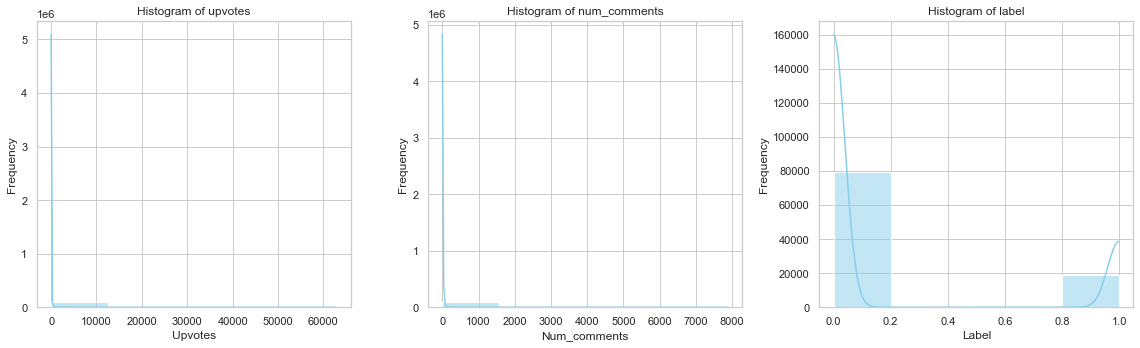

In [96]:
#Visualize the frequency distribution of values using histograms and to identify outliers using the box plots- for upvotes and num_comments

sns.set(style="whitegrid")
numeric_columns = ['upvotes', 'num_comments', 'label']

# Set up the subplot grid
fig, axes = plt.subplots(1, len(numeric_columns), figsize=(16, 5))

for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], bins=5, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

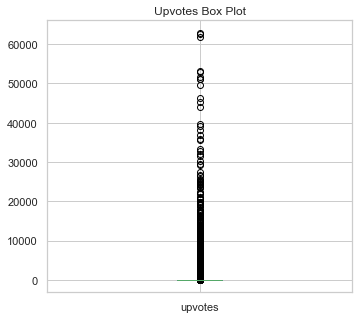

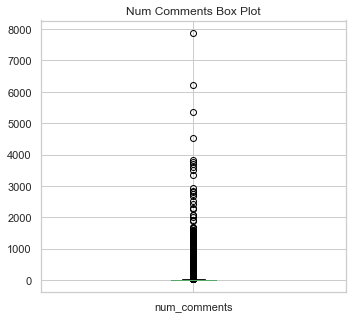

In [97]:
# Upvotes box plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
df['upvotes'].plot(kind='box')
plt.title('Upvotes Box Plot')
plt.show()

#for num_comments
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
df['num_comments'].plot(kind='box')
plt.title('Num Comments Box Plot')
plt.show()

In [98]:
#Frequency of categorical columns

# Frequency of 'subreddit' column
print(df['subreddit'].value_counts())

# Frequency of 'label' column
print(df['label'].value_counts())

# Set style
sns.set(style="whitegrid")

# Plot the counts for 'subreddit' column
plt.figure(figsize=(12, 6))
sns.countplot(df=df, y='subreddit', order=df['subreddit'].value_counts().index, palette='viridis')
plt.title('Counts of Posts by Subreddit')
plt.xlabel('Count')
plt.ylabel('Subreddit')
plt.show()

# Plot the counts for 'label' column
plt.figure(figsize=(8, 6))
sns.countplot(df=df, x='label', palette='coolwarm')
plt.title('Counts by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-suicidal', 'Suicidal'])
plt.show()

teenagers       78251
depression      11672
SuicideWatch     7544
happy             995
DeepThoughts      364
Name: subreddit, dtype: int64
0.0    79610
1.0    19216
Name: label, dtype: int64


ValueError: Could not interpret input 'subreddit'

<Figure size 864x432 with 0 Axes>

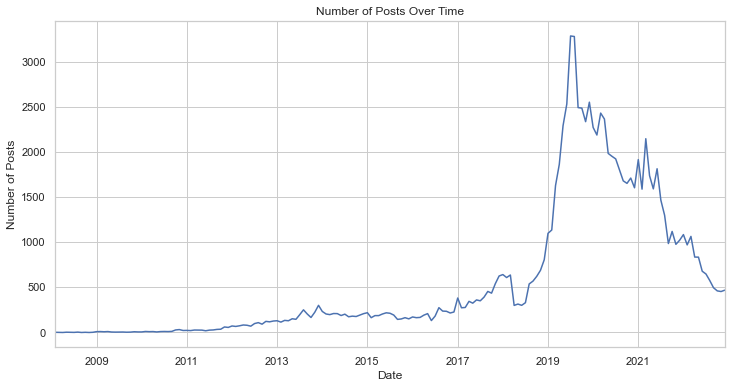

In [ ]:
# Plot number of posts over time
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df.set_index('created_utc', inplace=True)

# Plot number of posts per month
df.resample('M').size().plot(figsize=(12, 6))
plt.title('Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

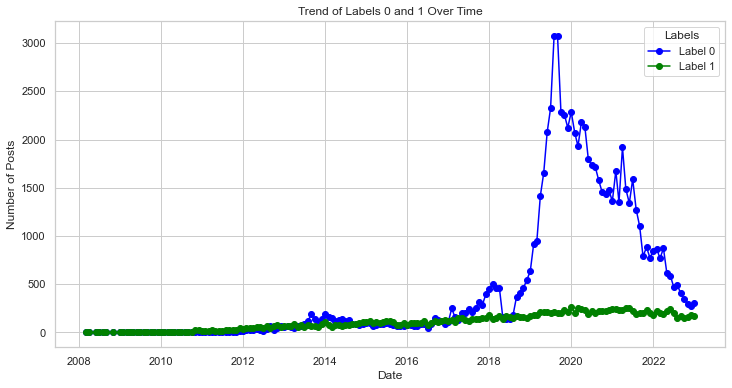

In [ ]:
# Resample the data by month (change this to 'W' for weekly or 'D' for daily)
label_trend = df.resample('M')['label'].value_counts().unstack().fillna(0)

# Plot the trend over time for both labels
plt.figure(figsize=(12, 6))
plt.plot(label_trend.index, label_trend[0], label='Label 0', color='blue', marker='o')
plt.plot(label_trend.index, label_trend[1], label='Label 1', color='green', marker='o')

# Adding titles and labels
plt.title('Trend of Labels 0 and 1 Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend(title='Labels')
plt.grid(True)

# Show the plot
plt.show()


Bivariate Analysis

In [ ]:
#Numerical vs. Numerical (Scatter plot and correlation matrix)
#Scatter Plot - Shows the relationship between two numerical variables, upvotes and num_comments.

# Scatter plot for numerical variables
plt.figure(figsize=(8, 6))
sns.scatterplot(x='upvotes', y='num_comments', df=df, alpha=0.5)
plt.title("Scatter Plot of Upvotes vs. Number of Comments")
plt.xlabel("Upvotes")
plt.ylabel("Number of Comments")
plt.show()

# Correlation matrix and heatmap
correlation_matrix = df[['upvotes', 'num_comments']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

ValueError: Could not interpret value `upvotes` for parameter `x`

<Figure size 576x432 with 0 Axes>

In [ ]:
# Numerical vs. Categorical (Box plot and Violin plot)
# Box plot of 'upvotes' by 'label'
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='upvotes', df=df, palette='pastel')
plt.title("Box Plot of Upvotes by Label")
plt.xlabel("Label")
plt.ylabel("Upvotes")
plt.xticks(ticks=[0, 1], labels=["Non-Suicidal (0)", "Suicidal (1)"])
plt.show()

# Violin plot of 'num_comments' by 'subreddit'
plt.figure(figsize=(10, 6))
sns.violinplot(x='subreddit', y='num_comments', df=df, palette='muted')
plt.title("Violin Plot of Number of Comments by Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Number of Comments")
plt.show()

ValueError: Could not interpret input 'label'

<Figure size 576x432 with 0 Axes>

In [ ]:
# Crosstab between 'subreddit' and 'label'
crosstab = pd.crosstab(df['subreddit'], df['label'])
print("Crosstab of Subreddit by Label:")
print(crosstab)

# Bar plot for 'subreddit' and 'label'
plt.figure(figsize=(10, 6))
sns.countplot(df=df, x="subreddit", hue="label", palette="Set2")
plt.title("Subreddit Distribution by Label")
plt.xlabel("Subreddit")
plt.ylabel("Count")
plt.legend(title="Label", loc='upper right', labels=["Non-Suicidal (0)", "Suicidal (1)"])
plt.show()

Crosstab of Subreddit by Label:
label           0.0    1.0
subreddit                 
DeepThoughts    364      0
SuicideWatch      0   7544
depression        0  11672
happy           995      0
teenagers     78251      0


ValueError: Could not interpret input 'subreddit'

<Figure size 720x432 with 0 Axes>

Multivariate Analysis

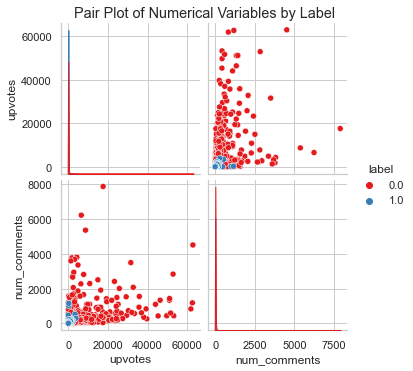

In [ ]:
# Pair plot with 'label' as the hue
sns.pairplot(df[['upvotes', 'num_comments', 'created_utc', 'label']], hue='label', palette='Set1', diag_kind='kde')
plt.suptitle("Pair Plot of Numerical Variables by Label", y=1.02)
plt.show()

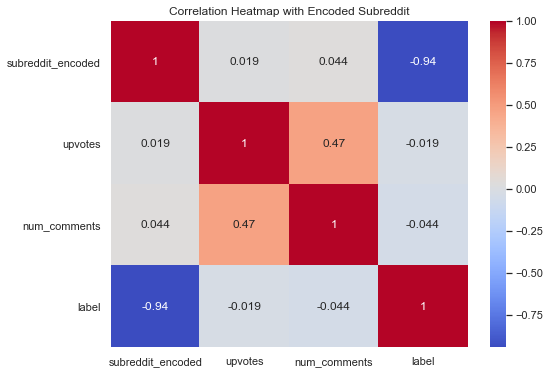

In [ ]:
# Convert the 'subreddit' column to numeric using label encoding
df['subreddit_encoded'] = LabelEncoder().fit_transform(df['subreddit'])

# Now include the encoded 'subreddit' in the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['subreddit_encoded', 'upvotes', 'num_comments', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Encoded Subreddit')
plt.show()

In [ ]:
# --- 1. Feature Creation ---
# Convert 'created_utc' to datetime format
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Extract year, month, day, hour from 'created_utc'
df['year'] = df['created_utc'].dt.year
df['month'] = df['created_utc'].dt.month
df['day'] = df['created_utc'].dt.day
df['hour'] = df['created_utc'].dt.hour

# Create additional features like ratios or flags
df['upvotes_per_comment'] = df['upvotes'] / (df['num_comments'] + 1)  # Adding 1 to avoid division by zero
df['has_body'] = df['body'].apply(lambda x: 0 if x == 'No content' else 1)  # Flag indicating if there's content in 'body'

# --- 2. Feature Encoding ---
# Encode the 'subreddit' categorical feature using one-hot encoding
df = pd.get_dummies(df, columns=['subreddit'], drop_first=True)

# --- 3. Scaling and Normalization ---
# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply Standard Scaling on numerical features
df[['upvotes', 'num_comments', 'upvotes_per_comment']] = standard_scaler.fit_transform(
    df[['upvotes', 'num_comments', 'upvotes_per_comment']]
)

# Apply Min-Max Scaling on year, month, day, hour (optional)
df[['year', 'month', 'day', 'hour']] = minmax_scaler.fit_transform(
    df[['year', 'month', 'day', 'hour']]
)

# Display the final DataFrame
print(df)

                                                   title  \
0                            Day 18 of doing 50 push-ups   
1      There isn’t a better feeling than finishing yo...   
2      LMAOOO I can only get this guy to talk to me i...   
3                           This isn't going to work out   
4      Am I the only guy who found it hurtful as a ch...   
...                                                  ...   
98821       Has anyone ever had any problems with gangs?   
98822  Moments away from killing myself, not even bot...   
98823      I've grown used to being like this for years.   
98824  This speech from The Lord of the Rings really ...   
98825                              I just don't know....   

                                                    body   upvotes  \
0                                             No content -0.062214   
1      Then your teacher hits you with that “ Good jo... -0.059013   
2                                  Yeahhh maybe not babe -0.062214   